# Mixture of Gaussian with Constraint

In [249]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.cluster import KMeans
from scipy.stats import norm
import seaborn as sns; sns.set()

In [250]:
def init(n_cluster, std, X):
    Phi = np.full((n_cluster, ), 1 / n_cluster)
    kmeans = KMeans(n_clusters=n_cluster).fit(X[:, None])
    Mu = kmeans.cluster_centers_.reshape(-1,)
    return Phi, Mu 

In [251]:
def e_step(X, Phi, Mu, std):
    # w_ij
    W = np.zeros((len(X), len(Phi))) 
    Norms = [norm(mu, std) for mu in Mu] 
    for i, x in enumerate(X):
        probs = [n.pdf(x) for n in Norms] 
        W[i, :] = (Phi * probs) / np.sum(Phi * probs)
    W = np.nan_to_num(W)
    return W

In [252]:
def m_step(X, W):
    Phi = W.mean(axis=0)
    Mu = (W.T * X).T.sum(axis=0) / W.sum(axis=0)
    return Phi, Mu

In [253]:
def converged(old_Mu, Mu):
    return np.allclose(old_Mu, Mu, 1e-5)

In [254]:
def em(X, n_cluster, std):
    Phi, old_Mu = init(n_cluster, std, X)
    Mu = old_Mu + 1
    while not converged(old_Mu, Mu):
        W = e_step(X, Phi, Mu, std)
        old_Mu = Mu.copy()
        Phi, Mu = m_step(X, W)
        print(".", end='')
    return W, Phi, Mu

In [255]:
def log_likelihood(X, W, Mu, std):
    means = Mu[W.argmax(axis=1)]
    Norms = [norm(mu, std) for mu in means]
    likes = [n.pdf(x) for n, x in zip(Norms, X)]
    print(sum(likes))

In [256]:
np.random.seed(0)
X = np.linspace(-5,5,num=20)
X0 = X*np.random.randn(len(X)) * 20 + 5 # Create data cluster 1
X1 = X*np.random.randn(len(X)) * 20 - 5 # Create data cluster 2
X2 = X*np.random.randn(len(X)) # Create data cluster 3
X_tot = np.stack((X0,X1,X2)).flatten() # Combine the clusters to get the random datapoints from above

In [257]:
W, Phi, Mu = em(X_tot, 6, 1)

..

In [258]:
log_likelihood(X, W, Mu, 1)

0.39691070418663565


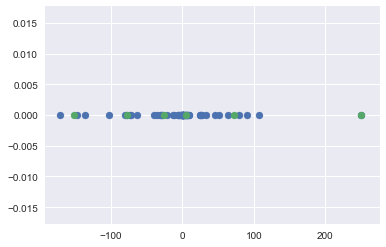

In [259]:
plt.scatter(X_tot, np.zeros(len(X_tot)))
plt.scatter(Mu, np.zeros(len(Mu)))

In [260]:
def extract_data():
    data = []
    for f in os.listdir("PCA_results/"):
        if not f.startswith(".") and f.startswith("sub"):
            data.append(pd.read_csv(os.path.join("PCA_results", f)).values)
    return np.stack(data)

In [261]:
data = extract_data()

In [262]:
manual = data[:, :, 0]
visual = data[:, :, 3]

In [263]:
from sklearn.preprocessing import StandardScaler

In [264]:
visual_scale = StandardScaler().fit_transform(visual)

In [271]:
W, Phi, Mu = em(visual[0], 10, 0.2)
log_likelihood(visual[0], W, Mu, 0.2)

/usr/local/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


........48.35612566389834


In [272]:
W, Phi, Mu = em(visual[0], 20, 0.2)
log_likelihood(visual[0], W, Mu, 0.2)

......78.15893258122085


In [273]:
W, Phi, Mu = em(visual[0], 30, 0.2)
log_likelihood(visual[0], W, Mu, 0.2)

........115.53838080294395


In [274]:
W, Phi, Mu = em(visual[0], 40, 0.2)
log_likelihood(visual[0], W, Mu, 1)

............117.05459976070564


In [276]:
for i in range(10, 180, 10):
    W, Phi, Mu = em(visual[0], i, 0.2)
    log_likelihood(visual[0], W, Mu, 0.2)

/usr/local/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


...49.47050274491996
...........68.15753631377437
........122.96937092226474
............163.02317075742414
.............238.13785324535326
.........249.67723648715372
............349.49142122259406
..........396.50674491604735
.........446.6541011494582
........477.9358879293972
........508.79615847274397
.......544.109653723291
.......565.9006392114006
....575.1138975321461
....583.3795633329419
.....594.6513930933731
.....600.7875041610578
